# Imports

In [311]:
import numpy as np
import pandas as pd
import random as rand
import matplotlib.pyplot as plt
import tensorflow as tf
import csv

from keras.utils import to_categorical
from keras.layers import Dense, Activation, Conv2D,Conv2DTranspose, Dropout, Reshape, MaxPooling2D, Flatten, LeakyReLU, BatchNormalization
from keras.models import Sequential, load_model
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam


from sklearn.model_selection import train_test_split

# Parameters

In [312]:
N_EPOCHS = 500
BATCH_SIZE = 16
DATASET_SIZE = 249
TRAIN_DATA_SIZE = 96
LATENT_DIM = 128

# Data importing and pre-processing

In [313]:
df = pd.read_csv('dataset.csv', header=None)


df = df.values.reshape(DATASET_SIZE, 64, 64, 1)

x_real_train, x_real_test = train_test_split(df, test_size=0.2) #12 test values


normalize dataset data into range of sigmoid [0,1], and put into batches

In [314]:
x_real_train = x_real_train.astype('float32')
x_real_train /=255


training_data = tf.data.Dataset.from_tensor_slices(x_real_train).shuffle(TRAIN_DATA_SIZE).batch(BATCH_SIZE)

Visualise example from dataset

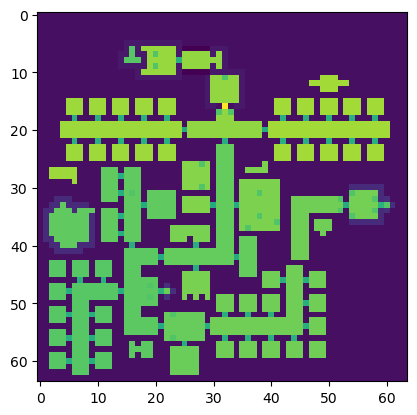

In [315]:
plt.imshow(df[0])

# Generator Model

Create points in latent space to be fed into generator

In [316]:
def generate_generator_input(no_of_maps):
    input = tf.random.normal(shape=(no_of_maps, LATENT_DIM))
    
    return input

In [317]:
def make_generator():
    model = Sequential()
    
    model.add(Dense(LATENT_DIM*8*8, input_shape=(LATENT_DIM,)))

    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Reshape((8,8,LATENT_DIM)))


    
    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', use_bias=False, input_shape=(8,8,60)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())


    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', use_bias=False, input_shape=(16,16,60)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    


    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', use_bias=False, input_shape=(32,32,60)))
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, kernel_size=5, padding="same"))
    model.add(Activation("sigmoid"))
    
              
    model.summary()
    
    return model
    
    

# Discriminator Model

In [318]:

def make_discriminator():
    
    # 1st set of layers
    model = Sequential()
    model.add(Conv2D(16, kernel_size=4, strides=2, padding="same", input_shape=(64,64,1)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    #model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
    

    model.add(Conv2D(16, kernel_size=4, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    #model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
    
    '''
    model.add(Conv2D(16, kernel_size=4, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    #model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
    '''
    model.add(Dense(100, activation='relu'))
    #model.add(Activation='relu')
    
    # output layer
    model.add(Flatten())
    model.add(Dropout(0.2))
    
    model.add(Dense(1)) # Binary classification (2 outputs), so only 1 dense layer needed
    model.add(Activation('sigmoid'))
    
    model.summary()
    return model
    

Create the models from the functions

In [319]:
gen_model = make_generator()

disc_model = make_discriminator()


Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_43 (Dense)            (None, 8192)              1056768   
                                                                 
 batch_normalization_99 (Ba  (None, 8192)              32768     
 tchNormalization)                                               
                                                                 
 leaky_re_lu_117 (LeakyReLU  (None, 8192)              0         
 )                                                               
                                                                 
 reshape_18 (Reshape)        (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_72 (Conv2  (None, 16, 16, 128)       262144    
 DTranspose)                                                     
                                                     

Next, test the untrained discriminator on the map of noise generated before

Negative values means fake, positive means real

## Loss and Optimizers

In [320]:
cross_entropy = BinaryCrossentropy(from_logits=True)



Discriminator loss, taken from: https://www.tensorflow.org/tutorials/generative/dcgan

In [321]:
def discrim_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

Generator loss

In [322]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Optimizers:

In [323]:
gen_optimizer = Adam(learning_rate =0.0002, beta_1=0.5)
disc_optimizer = Adam(learning_rate =0.0002, beta_1=0.5)

Discriminator accuracy

In [324]:
def compute_discrim_accuracy(real_output, fake_output):
    if real_output[0] >=0:
        
        if fake_output[0] <0:
            accuracy = (real_output[0] + fake_output[0]) / (real_output[0] + fake_output[0])
        else:
            accuracy = real_output[0]/ (real_output[0] + fake_output[0])
    elif fake_output[0] <0:
        accuracy = fake_output[0] / (real_output[0] + fake_output[0])
    else:
        accuracy = 0/ (real_output[0] + fake_output[0])
    
    return accuracy

## Training

Training step

In [325]:
@tf.function
def training_step(current_batch):
    
    noise_sample = generate_generator_input(BATCH_SIZE)
    

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        generated_map = gen_model(noise_sample, training=True)
        print("generated map shape" + str(generated_map.shape))
        
        fake_output = disc_model(generated_map,  training=True)
        real_output = disc_model(current_batch, training=True)
        

        gen_loss = generator_loss(fake_output=fake_output)
        disc_loss = discrim_loss(real_output=real_output, fake_output=fake_output)

        disc_accuracy = compute_discrim_accuracy(real_output, fake_output)

        

    gen_gradients = gen_tape.gradient(gen_loss, gen_model.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, disc_model.trainable_variables)

    gen_optimizer.apply_gradients(zip(gen_gradients, gen_model.trainable_variables))
    disc_optimizer.apply_gradients(zip(disc_gradients, disc_model.trainable_variables))

    return gen_loss, disc_loss, disc_accuracy

Train models

In [326]:
def train(dataset, N_EPOCHS):

    gen_losses = []
    disc_losses = []

    disc_accuracies = []
    
    img_seed = generate_generator_input(1)

    for epoch in range(N_EPOCHS):
        gen_losses_for_epoch = []
        disc_losses_for_epoch = []

        disc_accuracies_for_epoch = []

        print("epoch = " + str(epoch))

        for map_batch in dataset:
            
            
            gen_loss, disc_loss, disc_accuracy = training_step(map_batch)

            gen_losses_for_epoch.append(gen_loss)
            disc_losses_for_epoch.append(disc_loss)
            disc_accuracies.append(disc_accuracy)
        
        avg_gen_loss = sum(gen_losses_for_epoch) / TRAIN_DATA_SIZE
        avg_disc_loss = sum(disc_losses_for_epoch) / TRAIN_DATA_SIZE

        avg_disc_accuracy = sum(disc_accuracies_for_epoch) / TRAIN_DATA_SIZE

        gen_losses.append(avg_gen_loss)
        disc_losses.append(avg_disc_loss)

        disc_accuracies.append(avg_disc_accuracy)

        print("Gen loss = " + str(avg_gen_loss))
        print("Disc loss = " + str(avg_disc_loss))

        print("Disc accuracy = " + str(avg_disc_accuracy))
# generate and show a map after 10 epochs

        if epoch % 10 == 0:
            
            generated_map = gen_model(img_seed, training=False)
            generated_map *= 255
            generated_map = generated_map.numpy()
            generated_map.reshape(64,64)
            generated_map = np.round(generated_map,0)
            generated_map = generated_map.tolist()
            plt.imshow(generated_map[0])
            plt.show()
    
    input_for_map_after_training = generate_generator_input(1)
    generated_map = gen_model(input_for_map_after_training, training=False)

    

    return gen_losses, disc_losses, generated_map, disc_accuracies


Train GAN

epoch = 0
generated map shape(16, 64, 64, 1)


/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


generated map shape(16, 64, 64, 1)
Gen loss = tf.Tensor(0.03542279, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.099383675, shape=(), dtype=float32)
Disc accuracy = 0.0


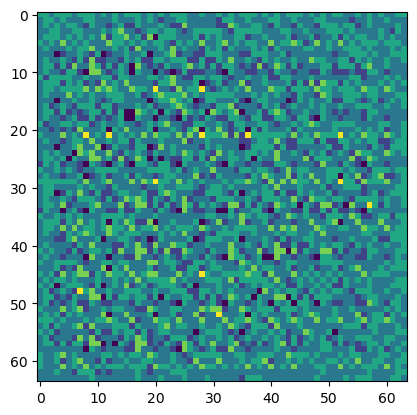

epoch = 1
Gen loss = tf.Tensor(0.045657635, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07695223, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 2
Gen loss = tf.Tensor(0.03804739, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08941743, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 3
Gen loss = tf.Tensor(0.05978331, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.06354567, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 4
Gen loss = tf.Tensor(0.057860736, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.061520208, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 5
Gen loss = tf.Tensor(0.038252186, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08936522, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 6
Gen loss = tf.Tensor(0.044623632, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08442987, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 7
Gen loss = tf.Tensor(0.048644725, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07596185, shape=(), 

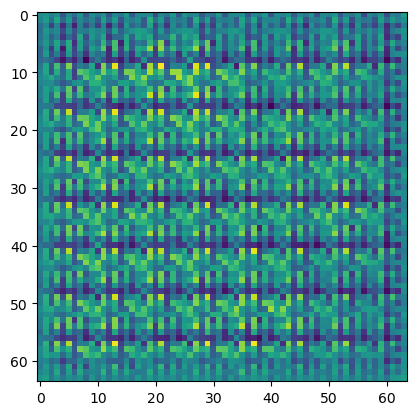

epoch = 11
Gen loss = tf.Tensor(0.054644544, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08158227, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 12
Gen loss = tf.Tensor(0.06309986, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.05683161, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 13
Gen loss = tf.Tensor(0.07453843, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.05354591, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 14
Gen loss = tf.Tensor(0.060462754, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.056419536, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 15
Gen loss = tf.Tensor(0.07163458, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.054110583, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 16
Gen loss = tf.Tensor(0.06950254, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.05102991, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 17
Gen loss = tf.Tensor(0.06515236, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.058395263, shap

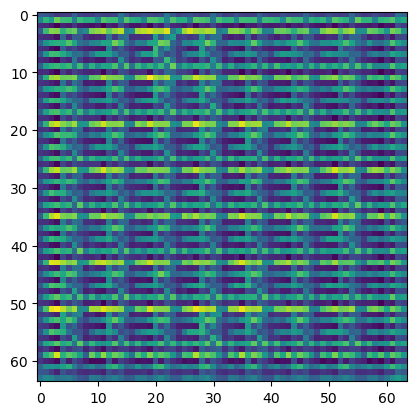

epoch = 21
Gen loss = tf.Tensor(0.07878774, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.05766358, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 22
Gen loss = tf.Tensor(0.08579589, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.03626069, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 23
Gen loss = tf.Tensor(0.060100153, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.059888277, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 24
Gen loss = tf.Tensor(0.07394565, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.049132142, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 25
Gen loss = tf.Tensor(0.10072119, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.034991983, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 26
Gen loss = tf.Tensor(0.07413039, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04744256, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 27
Gen loss = tf.Tensor(0.07203206, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.052985255, shap

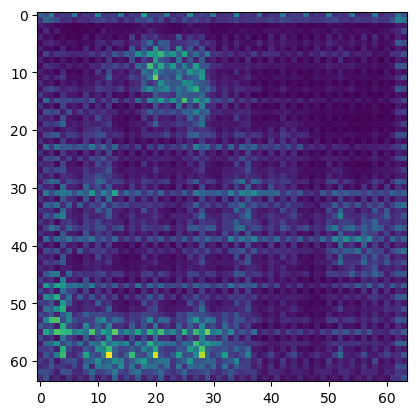

epoch = 31
Gen loss = tf.Tensor(0.058325227, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.074696384, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 32
Gen loss = tf.Tensor(0.055905897, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07303667, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 33
Gen loss = tf.Tensor(0.046843052, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08760086, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 34
Gen loss = tf.Tensor(0.048953872, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08379813, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 35
Gen loss = tf.Tensor(0.04858631, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08495906, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 36
Gen loss = tf.Tensor(0.03664914, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.111739196, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 37
Gen loss = tf.Tensor(0.047336806, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09238104, sh

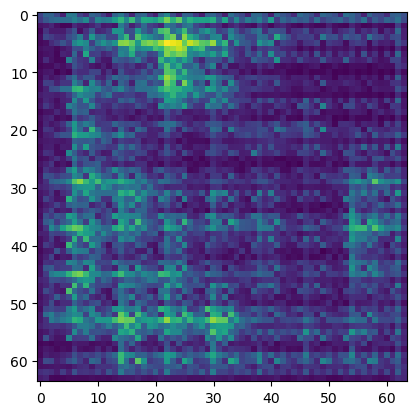

epoch = 41
Gen loss = tf.Tensor(0.05256751, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08386584, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 42
Gen loss = tf.Tensor(0.039724972, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.103927575, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 43
Gen loss = tf.Tensor(0.0527119, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.080564745, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 44
Gen loss = tf.Tensor(0.0458023, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08783519, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 45
Gen loss = tf.Tensor(0.0475648, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08952671, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 46
Gen loss = tf.Tensor(0.044973895, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09155804, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 47
Gen loss = tf.Tensor(0.040292133, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09914126, shape=(

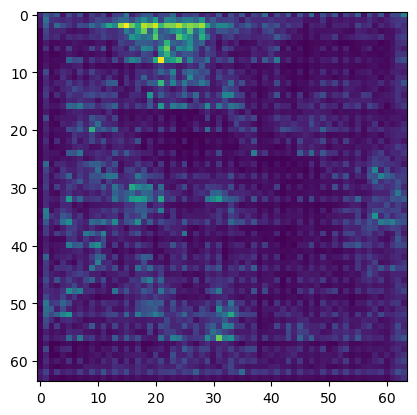

epoch = 51
Gen loss = tf.Tensor(0.037410837, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.10256231, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 52
Gen loss = tf.Tensor(0.03469916, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.1113322, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 53
Gen loss = tf.Tensor(0.032994654, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.119046606, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 54
Gen loss = tf.Tensor(0.035073478, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.11460283, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 55
Gen loss = tf.Tensor(0.03955916, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.104418516, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 56
Gen loss = tf.Tensor(0.036528774, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.10790065, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 57
Gen loss = tf.Tensor(0.036244053, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.11082538, sha

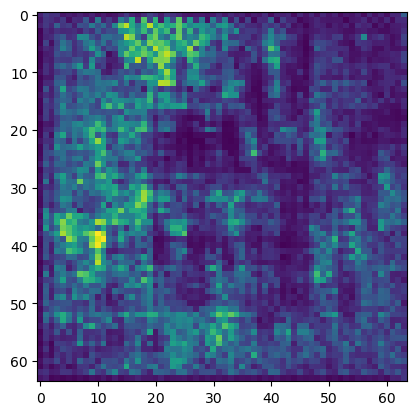

epoch = 61
Gen loss = tf.Tensor(0.036137134, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.10835212, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 62
Gen loss = tf.Tensor(0.03746534, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.107773595, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 63
Gen loss = tf.Tensor(0.038701594, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.1012902, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 64
Gen loss = tf.Tensor(0.038963232, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.10197517, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 65
Gen loss = tf.Tensor(0.037610125, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.10343631, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 66
Gen loss = tf.Tensor(0.038934957, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.10100833, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 67
Gen loss = tf.Tensor(0.03990997, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09995798, shap

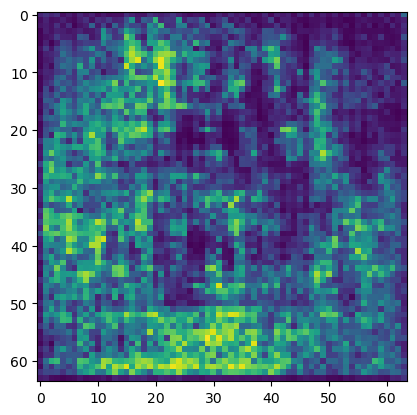

epoch = 71
Gen loss = tf.Tensor(0.041585453, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09685012, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 72
Gen loss = tf.Tensor(0.0429726, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09086559, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 73
Gen loss = tf.Tensor(0.039205503, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09803193, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 74
Gen loss = tf.Tensor(0.040489998, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09694167, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 75
Gen loss = tf.Tensor(0.041756187, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09434739, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 76
Gen loss = tf.Tensor(0.044993054, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.087089635, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 77
Gen loss = tf.Tensor(0.039936986, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09641448, sha

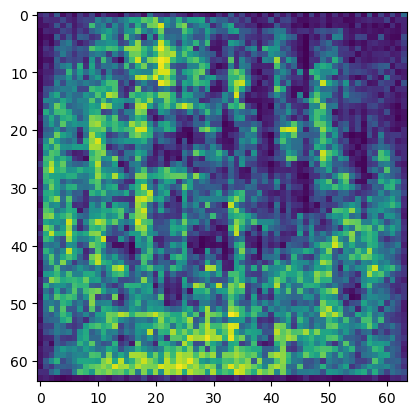

epoch = 81
Gen loss = tf.Tensor(0.042511035, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08970952, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 82
Gen loss = tf.Tensor(0.04031693, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.096668445, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 83
Gen loss = tf.Tensor(0.038776997, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.101099454, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 84
Gen loss = tf.Tensor(0.044737946, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08958894, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 85
Gen loss = tf.Tensor(0.043493826, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08717426, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 86
Gen loss = tf.Tensor(0.043314125, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.091259025, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 87
Gen loss = tf.Tensor(0.041651558, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09422624, 

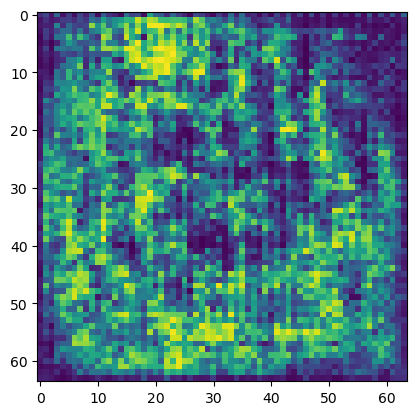

epoch = 91
Gen loss = tf.Tensor(0.041977257, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09309884, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 92
Gen loss = tf.Tensor(0.04386741, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09010353, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 93
Gen loss = tf.Tensor(0.045316037, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08605201, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 94
Gen loss = tf.Tensor(0.04786734, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.082921244, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 95
Gen loss = tf.Tensor(0.044363227, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08752587, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 96
Gen loss = tf.Tensor(0.042542044, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.089330345, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 97
Gen loss = tf.Tensor(0.045047164, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08786284, sh

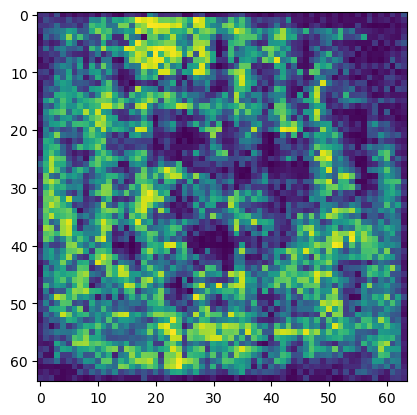

epoch = 101
Gen loss = tf.Tensor(0.044407994, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08870446, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 102
Gen loss = tf.Tensor(0.046433553, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08595276, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 103
Gen loss = tf.Tensor(0.047363117, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08067695, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 104
Gen loss = tf.Tensor(0.04460006, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08696615, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 105
Gen loss = tf.Tensor(0.042987812, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09098951, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 106
Gen loss = tf.Tensor(0.04499783, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08750708, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 107
Gen loss = tf.Tensor(0.045347806, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0847213

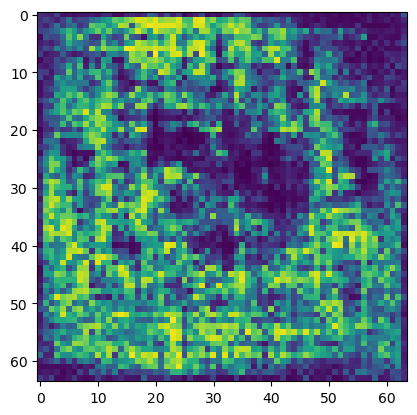

epoch = 111
Gen loss = tf.Tensor(0.046135142, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08468955, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 112
Gen loss = tf.Tensor(0.04720624, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.083023645, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 113
Gen loss = tf.Tensor(0.045270547, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08622113, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 114
Gen loss = tf.Tensor(0.045560982, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08549861, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 115
Gen loss = tf.Tensor(0.047708917, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08150314, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 116
Gen loss = tf.Tensor(0.047871623, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08152979, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 117
Gen loss = tf.Tensor(0.045079235, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08404

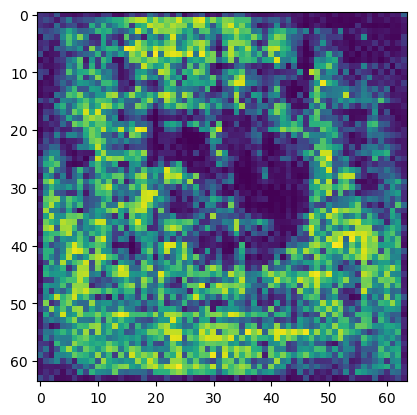

epoch = 121
Gen loss = tf.Tensor(0.04654182, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.083717585, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 122
Gen loss = tf.Tensor(0.045262564, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08550894, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 123
Gen loss = tf.Tensor(0.0460415, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.082741156, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 124
Gen loss = tf.Tensor(0.048405036, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.082353465, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 125
Gen loss = tf.Tensor(0.047350828, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08243476, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 126
Gen loss = tf.Tensor(0.047022033, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.081869535, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 127
Gen loss = tf.Tensor(0.046510175, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0826

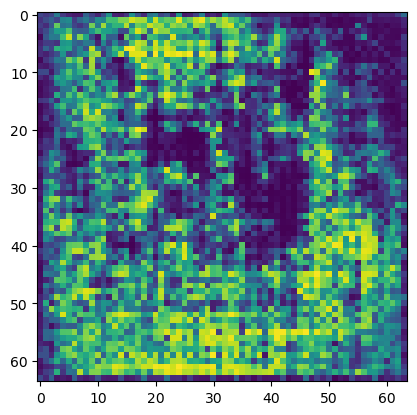

epoch = 131
Gen loss = tf.Tensor(0.047494832, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.081846274, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 132
Gen loss = tf.Tensor(0.04730472, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08127811, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 133
Gen loss = tf.Tensor(0.046583205, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.083017826, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 134
Gen loss = tf.Tensor(0.04938617, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.078066334, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 135
Gen loss = tf.Tensor(0.046242487, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08377855, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 136
Gen loss = tf.Tensor(0.047674358, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08184579, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 137
Gen loss = tf.Tensor(0.05002285, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07852

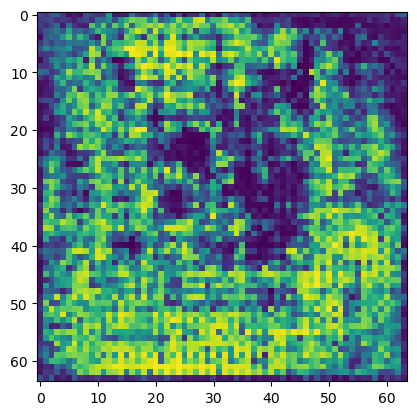

epoch = 141
Gen loss = tf.Tensor(0.049317297, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.078333, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 142
Gen loss = tf.Tensor(0.04817565, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08087318, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 143
Gen loss = tf.Tensor(0.047306042, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08240279, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 144
Gen loss = tf.Tensor(0.049593624, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07882141, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 145
Gen loss = tf.Tensor(0.04944779, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07890034, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 146
Gen loss = tf.Tensor(0.0481211, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0799525, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 147
Gen loss = tf.Tensor(0.048835, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0806149, shape=

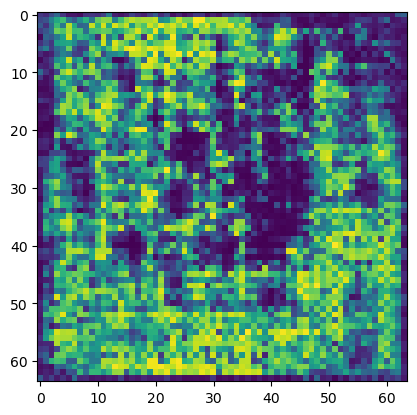

epoch = 151
Gen loss = tf.Tensor(0.048652466, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08139496, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 152
Gen loss = tf.Tensor(0.048868004, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07817871, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 153
Gen loss = tf.Tensor(0.04890959, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08096152, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 154
Gen loss = tf.Tensor(0.04858948, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07986785, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 155
Gen loss = tf.Tensor(0.049027238, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07919105, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 156
Gen loss = tf.Tensor(0.04909931, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.079195835, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 157
Gen loss = tf.Tensor(0.049531933, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0780151

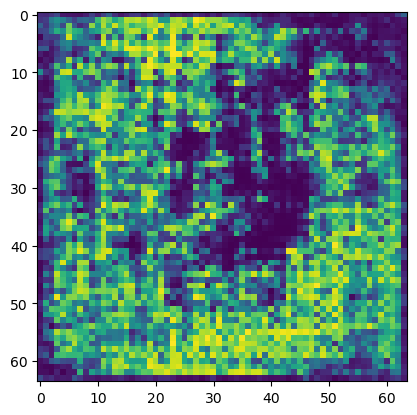

epoch = 161
Gen loss = tf.Tensor(0.04852714, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.079154015, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 162
Gen loss = tf.Tensor(0.048240002, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08091586, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 163
Gen loss = tf.Tensor(0.051171694, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07644463, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 164
Gen loss = tf.Tensor(0.048212502, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08110253, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 165
Gen loss = tf.Tensor(0.049482495, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07705699, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 166
Gen loss = tf.Tensor(0.049013954, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08080744, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 167
Gen loss = tf.Tensor(0.051249504, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07723

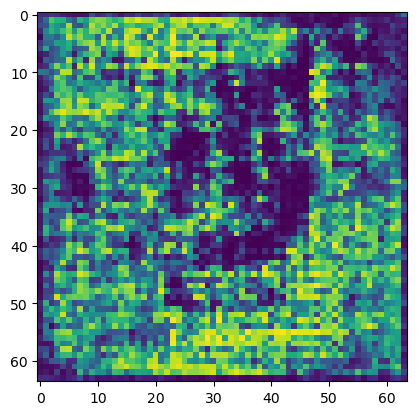

epoch = 171
Gen loss = tf.Tensor(0.048540443, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08059219, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 172
Gen loss = tf.Tensor(0.05224319, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.074012674, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 173
Gen loss = tf.Tensor(0.049867596, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07879921, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 174
Gen loss = tf.Tensor(0.051952112, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0742749, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 175
Gen loss = tf.Tensor(0.050598294, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07703615, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 176
Gen loss = tf.Tensor(0.05020799, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07854259, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 177
Gen loss = tf.Tensor(0.051709693, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0746227

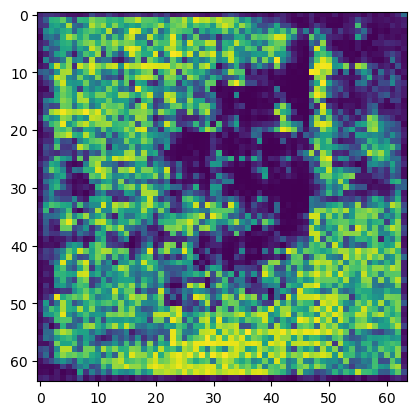

epoch = 181
Gen loss = tf.Tensor(0.051739607, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0745173, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 182
Gen loss = tf.Tensor(0.051123142, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0758454, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 183
Gen loss = tf.Tensor(0.050825078, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07618796, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 184
Gen loss = tf.Tensor(0.051125377, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07472595, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 185
Gen loss = tf.Tensor(0.049959052, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0773555, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 186
Gen loss = tf.Tensor(0.051225457, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07634028, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 187
Gen loss = tf.Tensor(0.050296854, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07671035

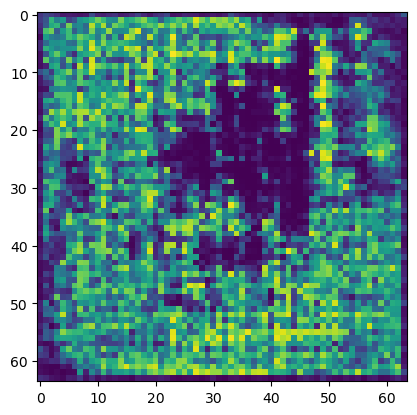

epoch = 191
Gen loss = tf.Tensor(0.050245453, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07738019, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 192
Gen loss = tf.Tensor(0.05164368, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07558168, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 193
Gen loss = tf.Tensor(0.051706802, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07550485, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 194
Gen loss = tf.Tensor(0.050407592, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07554153, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 195
Gen loss = tf.Tensor(0.05212882, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.073464565, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 196
Gen loss = tf.Tensor(0.051138043, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07819297, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 197
Gen loss = tf.Tensor(0.05290367, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0744716

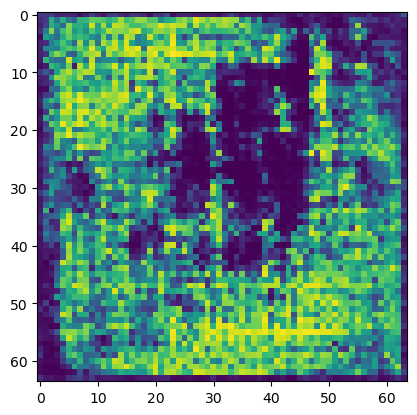

epoch = 201
Gen loss = tf.Tensor(0.052893773, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07300255, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 202
Gen loss = tf.Tensor(0.05101256, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.077726156, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 203
Gen loss = tf.Tensor(0.052088145, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07385482, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 204
Gen loss = tf.Tensor(0.049999, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07737804, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 205
Gen loss = tf.Tensor(0.051831465, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07416255, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 206
Gen loss = tf.Tensor(0.05323741, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.073844686, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 207
Gen loss = tf.Tensor(0.051674828, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07460836

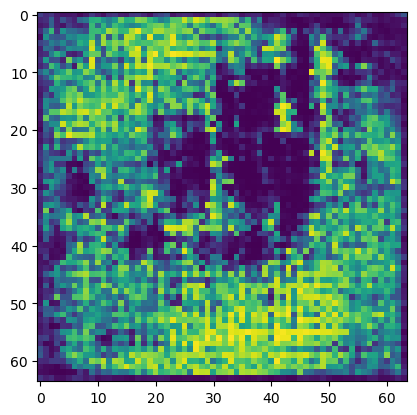

epoch = 211
Gen loss = tf.Tensor(0.052863333, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.072749116, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 212
Gen loss = tf.Tensor(0.051665317, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.077499755, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 213
Gen loss = tf.Tensor(0.052281454, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07288523, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 214
Gen loss = tf.Tensor(0.05186351, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.075083554, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 215
Gen loss = tf.Tensor(0.051273342, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07717321, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 216
Gen loss = tf.Tensor(0.054031506, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07178683, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 217
Gen loss = tf.Tensor(0.05028091, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0769

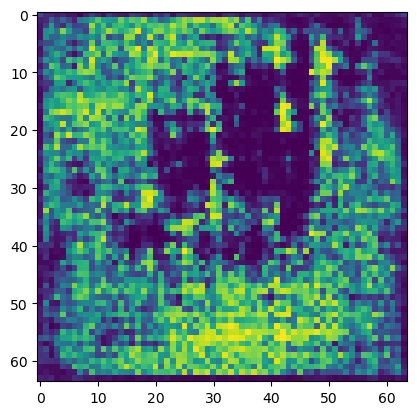

epoch = 221
Gen loss = tf.Tensor(0.052492056, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07391066, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 222
Gen loss = tf.Tensor(0.051739533, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.075256266, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 223
Gen loss = tf.Tensor(0.053996813, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07298757, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 224
Gen loss = tf.Tensor(0.052706342, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07359726, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 225
Gen loss = tf.Tensor(0.0529231, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07277885, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 226
Gen loss = tf.Tensor(0.051158782, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07717224, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 227
Gen loss = tf.Tensor(0.052677672, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.071827

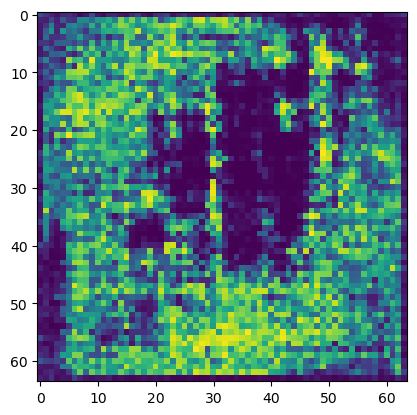

epoch = 231
Gen loss = tf.Tensor(0.052497882, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.074691445, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 232
Gen loss = tf.Tensor(0.05181655, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.074779235, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 233
Gen loss = tf.Tensor(0.052221898, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.073904954, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 234
Gen loss = tf.Tensor(0.05205415, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07571623, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 235
Gen loss = tf.Tensor(0.054794982, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.074632786, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 236
Gen loss = tf.Tensor(0.051747423, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07343801, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 237
Gen loss = tf.Tensor(0.052071046, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.074

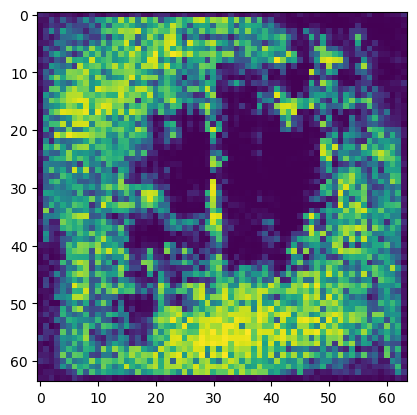

epoch = 241
Gen loss = tf.Tensor(0.054426286, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07079724, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 242
Gen loss = tf.Tensor(0.053739015, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.071826674, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 243
Gen loss = tf.Tensor(0.053434078, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07257296, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 244
Gen loss = tf.Tensor(0.051640034, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.076935865, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 245
Gen loss = tf.Tensor(0.05373797, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07127575, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 246
Gen loss = tf.Tensor(0.05379477, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.073145755, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 247
Gen loss = tf.Tensor(0.054971155, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0691

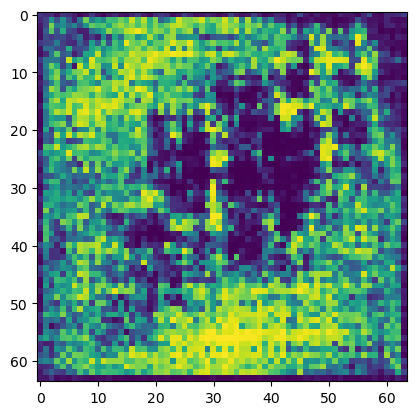

epoch = 251
Gen loss = tf.Tensor(0.05057719, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07551662, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 252
Gen loss = tf.Tensor(0.054946695, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.072274104, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 253
Gen loss = tf.Tensor(0.052544076, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.073643364, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 254
Gen loss = tf.Tensor(0.05585747, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.06978138, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 255
Gen loss = tf.Tensor(0.053441558, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07156304, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 256
Gen loss = tf.Tensor(0.055326045, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.06926563, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 257
Gen loss = tf.Tensor(0.058242172, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.06802

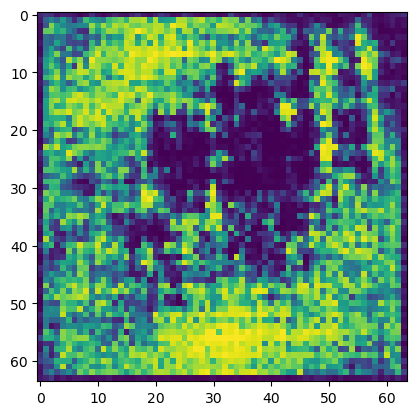

epoch = 261
Gen loss = tf.Tensor(0.056097377, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.070181794, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 262
Gen loss = tf.Tensor(0.057025462, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.068598665, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 263
Gen loss = tf.Tensor(0.05243865, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.073078826, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 264
Gen loss = tf.Tensor(0.052682895, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07335084, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 265
Gen loss = tf.Tensor(0.057319593, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.06856907, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 266
Gen loss = tf.Tensor(0.051188916, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07454469, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 267
Gen loss = tf.Tensor(0.056434214, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.070

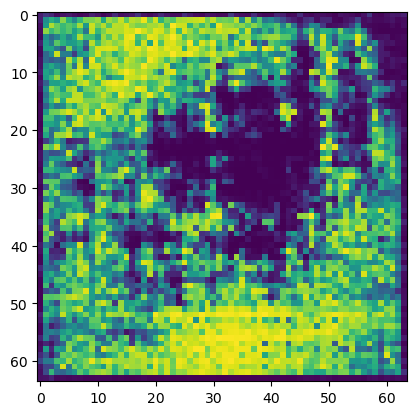

epoch = 271
Gen loss = tf.Tensor(0.054341167, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.071125016, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 272
Gen loss = tf.Tensor(0.05660971, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.06845554, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 273
Gen loss = tf.Tensor(0.056341093, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.06865044, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 274
Gen loss = tf.Tensor(0.056006487, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.06800901, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 275
Gen loss = tf.Tensor(0.055657763, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.070751555, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 276
Gen loss = tf.Tensor(0.0564445, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.067714885, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 277
Gen loss = tf.Tensor(0.053038348, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07431

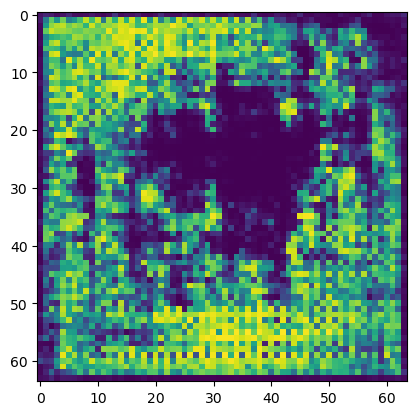

epoch = 281
Gen loss = tf.Tensor(0.057542343, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.066733815, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 282
Gen loss = tf.Tensor(0.056697685, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.067978725, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 283
Gen loss = tf.Tensor(0.05227604, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07511543, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 284
Gen loss = tf.Tensor(0.05686918, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.06857241, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 285
Gen loss = tf.Tensor(0.057132393, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0693355, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 286
Gen loss = tf.Tensor(0.055598885, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.069249466, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 287
Gen loss = tf.Tensor(0.055627275, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07044

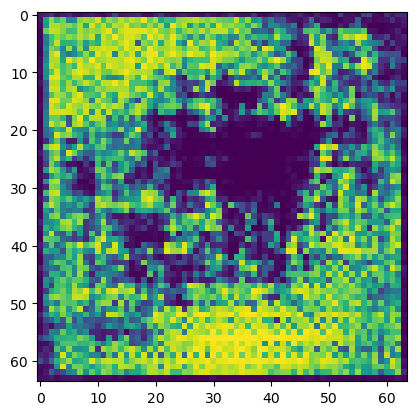

epoch = 291
Gen loss = tf.Tensor(0.057804186, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.06617685, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 292
Gen loss = tf.Tensor(0.054069456, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07052827, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 293
Gen loss = tf.Tensor(0.05610725, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07068316, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 294
Gen loss = tf.Tensor(0.056127895, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07087767, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 295
Gen loss = tf.Tensor(0.05280604, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07147502, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 296
Gen loss = tf.Tensor(0.056015566, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07087333, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 297
Gen loss = tf.Tensor(0.060202617, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0654233

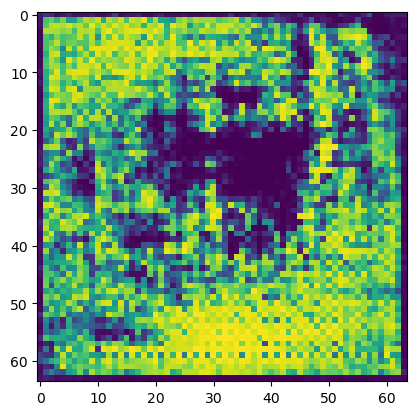

epoch = 301
Gen loss = tf.Tensor(0.059096556, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.067417584, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 302
Gen loss = tf.Tensor(0.059067577, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.06508073, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 303
Gen loss = tf.Tensor(0.059880406, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.064203404, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 304
Gen loss = tf.Tensor(0.055740505, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.068613075, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 305
Gen loss = tf.Tensor(0.059023127, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.06673365, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 306
Gen loss = tf.Tensor(0.058605015, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.06704589, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 307
Gen loss = tf.Tensor(0.056796253, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.06

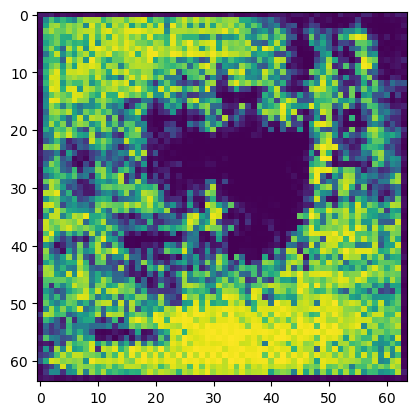

epoch = 311
Gen loss = tf.Tensor(0.059586715, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.06442976, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 312
Gen loss = tf.Tensor(0.05770747, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.06671586, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 313
Gen loss = tf.Tensor(0.057613045, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.06819939, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 314
Gen loss = tf.Tensor(0.058566425, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.06584084, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 315
Gen loss = tf.Tensor(0.05804874, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.06606483, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 316
Gen loss = tf.Tensor(0.0621262, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.064003915, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 317
Gen loss = tf.Tensor(0.061022475, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.06365528

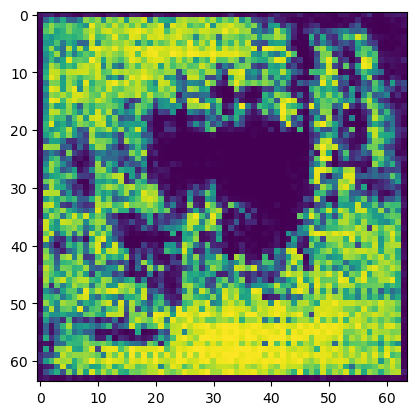

epoch = 321
Gen loss = tf.Tensor(0.05952312, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.066089205, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 322
Gen loss = tf.Tensor(0.061964247, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.06339987, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 323
Gen loss = tf.Tensor(0.060578305, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.06331552, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 324
Gen loss = tf.Tensor(0.05993661, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.064951114, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 325
Gen loss = tf.Tensor(0.061623167, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.062258523, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 326
Gen loss = tf.Tensor(0.06033018, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.062415097, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 327
Gen loss = tf.Tensor(0.060908694, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0646

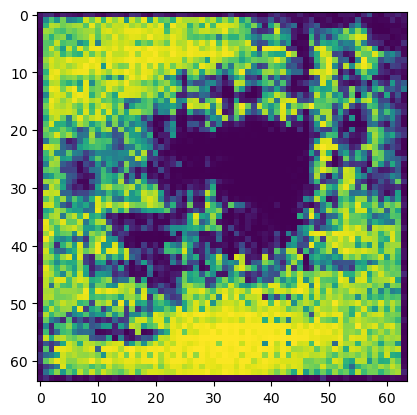

epoch = 331
Gen loss = tf.Tensor(0.061866175, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.061408844, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 332
Gen loss = tf.Tensor(0.062630065, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.06379313, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 333
Gen loss = tf.Tensor(0.058814798, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.06612587, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 334
Gen loss = tf.Tensor(0.06379416, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.06015399, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 335
Gen loss = tf.Tensor(0.063285135, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.060151923, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 336
Gen loss = tf.Tensor(0.06376437, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.061292574, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 337
Gen loss = tf.Tensor(0.06298926, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.05976

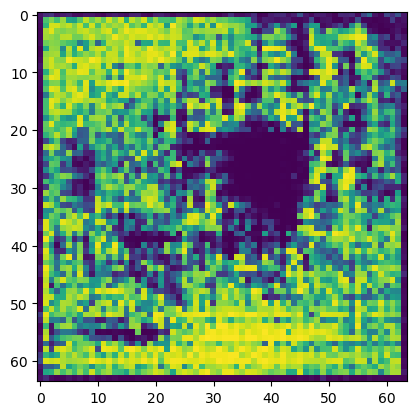

epoch = 341
Gen loss = tf.Tensor(0.061061725, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.062115256, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 342
Gen loss = tf.Tensor(0.063333616, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.060404405, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 343
Gen loss = tf.Tensor(0.06262501, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.061020415, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 344
Gen loss = tf.Tensor(0.0652861, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.06094731, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 345
Gen loss = tf.Tensor(0.06236506, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.061012402, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 346
Gen loss = tf.Tensor(0.06339339, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.059443574, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 347
Gen loss = tf.Tensor(0.065472566, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.05952

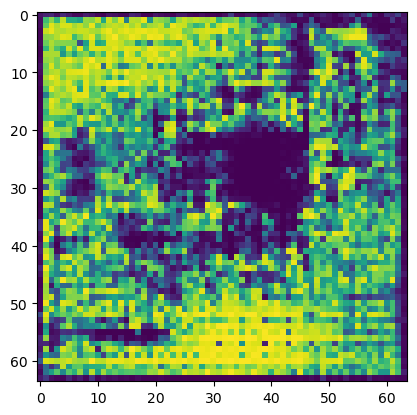

epoch = 351
Gen loss = tf.Tensor(0.062414136, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.06158988, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 352
Gen loss = tf.Tensor(0.06333998, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.061858192, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 353
Gen loss = tf.Tensor(0.066485085, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0579184, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 354
Gen loss = tf.Tensor(0.06047074, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0644831, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 355
Gen loss = tf.Tensor(0.07026677, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.056095142, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 356
Gen loss = tf.Tensor(0.060694773, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.061864924, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 357
Gen loss = tf.Tensor(0.0676213, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.058203608

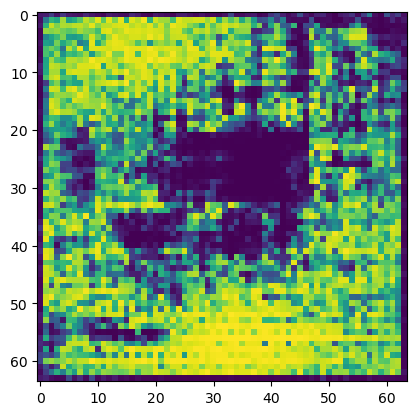

epoch = 361
Gen loss = tf.Tensor(0.062385622, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0608779, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 362
Gen loss = tf.Tensor(0.06506542, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.058860317, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 363
Gen loss = tf.Tensor(0.069371164, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.059819918, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 364
Gen loss = tf.Tensor(0.06317091, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.059288308, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 365
Gen loss = tf.Tensor(0.06957882, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.056073174, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 366
Gen loss = tf.Tensor(0.06579163, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.058756787, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 367
Gen loss = tf.Tensor(0.066889204, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.05811

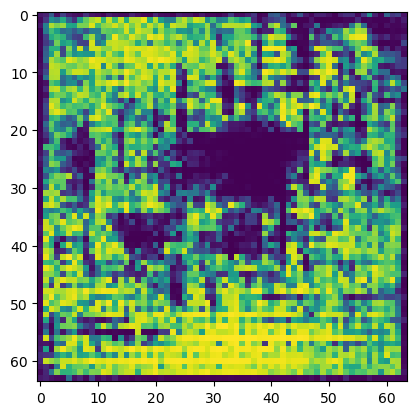

epoch = 371
Gen loss = tf.Tensor(0.06456243, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.05802247, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 372
Gen loss = tf.Tensor(0.06916382, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0574977, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 373
Gen loss = tf.Tensor(0.06701335, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.057697892, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 374
Gen loss = tf.Tensor(0.06551359, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.05829203, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 375
Gen loss = tf.Tensor(0.069589324, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.057111647, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 376
Gen loss = tf.Tensor(0.06651303, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.05718871, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 377
Gen loss = tf.Tensor(0.06954322, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.056582656,

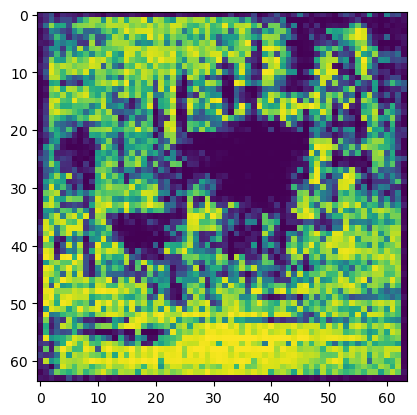

epoch = 381
Gen loss = tf.Tensor(0.06697614, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.060327858, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 382
Gen loss = tf.Tensor(0.06928505, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.055528533, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 383
Gen loss = tf.Tensor(0.066318035, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.058820244, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 384
Gen loss = tf.Tensor(0.06659097, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.058475107, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 385
Gen loss = tf.Tensor(0.06873734, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.057341743, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 386
Gen loss = tf.Tensor(0.07221646, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.057036042, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 387
Gen loss = tf.Tensor(0.06856536, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.05432

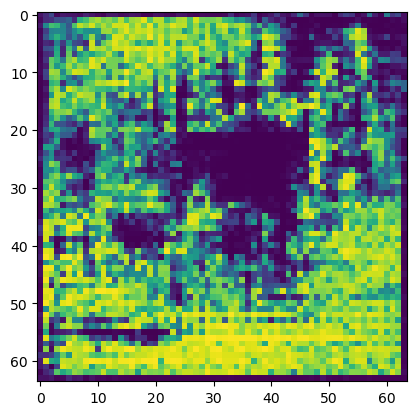

epoch = 391
Gen loss = tf.Tensor(0.06797375, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.058358382, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 392
Gen loss = tf.Tensor(0.07204161, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.054474995, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 393
Gen loss = tf.Tensor(0.06903787, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.055884913, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 394
Gen loss = tf.Tensor(0.06722965, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.055872258, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 395
Gen loss = tf.Tensor(0.06939353, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.055377673, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 396
Gen loss = tf.Tensor(0.06796424, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0570716, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 397
Gen loss = tf.Tensor(0.07032481, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.05432073

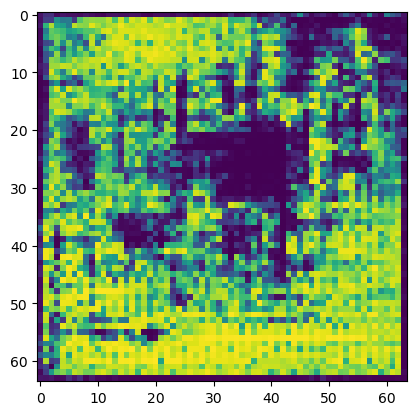

epoch = 401
Gen loss = tf.Tensor(0.07124271, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.053471226, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 402
Gen loss = tf.Tensor(0.06902194, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.055575103, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 403
Gen loss = tf.Tensor(0.07075247, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.055468064, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 404
Gen loss = tf.Tensor(0.06810094, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.055273134, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 405
Gen loss = tf.Tensor(0.07396423, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.052770242, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 406
Gen loss = tf.Tensor(0.07020754, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.055866305, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 407
Gen loss = tf.Tensor(0.074768245, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.05189

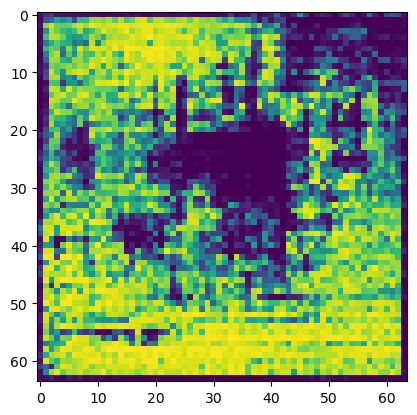

epoch = 411
Gen loss = tf.Tensor(0.072926775, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.053449646, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 412
Gen loss = tf.Tensor(0.071656995, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.057491165, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 413
Gen loss = tf.Tensor(0.07013894, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.052069772, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 414
Gen loss = tf.Tensor(0.073506765, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.053807717, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 415
Gen loss = tf.Tensor(0.075336404, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.052421674, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 416
Gen loss = tf.Tensor(0.07220524, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.051509764, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 417
Gen loss = tf.Tensor(0.0770315, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.049

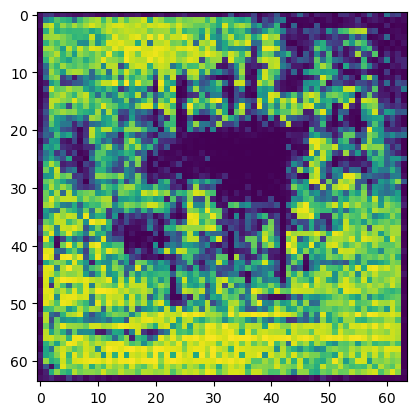

epoch = 421
Gen loss = tf.Tensor(0.06903266, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.05716378, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 422
Gen loss = tf.Tensor(0.07726825, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.048145365, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 423
Gen loss = tf.Tensor(0.0760879, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.050749857, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 424
Gen loss = tf.Tensor(0.0729807, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.05278487, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 425
Gen loss = tf.Tensor(0.076482125, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.05101162, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 426
Gen loss = tf.Tensor(0.07261115, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.057200503, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 427
Gen loss = tf.Tensor(0.07060505, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.05199444, 

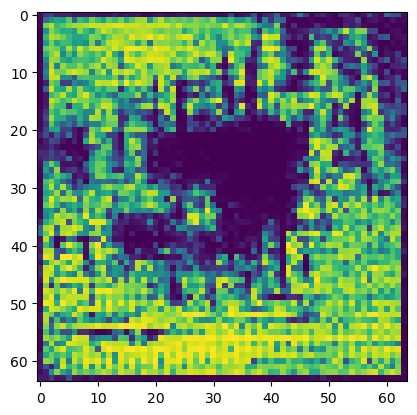

epoch = 431
Gen loss = tf.Tensor(0.077306546, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.050544668, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 432
Gen loss = tf.Tensor(0.07708354, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.051374763, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 433
Gen loss = tf.Tensor(0.07887442, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04843743, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 434
Gen loss = tf.Tensor(0.07805962, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04804924, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 435
Gen loss = tf.Tensor(0.07644122, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.052863896, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 436
Gen loss = tf.Tensor(0.07329382, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.05173147, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 437
Gen loss = tf.Tensor(0.07813452, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04877245

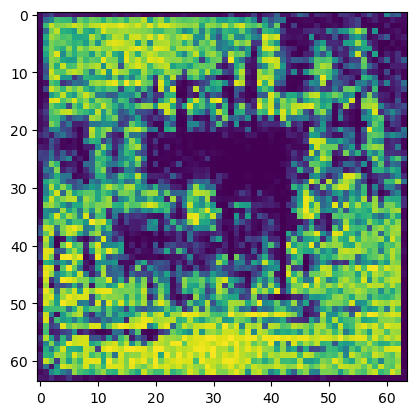

epoch = 441
Gen loss = tf.Tensor(0.07748068, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.048024807, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 442
Gen loss = tf.Tensor(0.07545953, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.052474607, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 443
Gen loss = tf.Tensor(0.07648917, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.050757516, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 444
Gen loss = tf.Tensor(0.080038756, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04564294, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 445
Gen loss = tf.Tensor(0.079876564, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.046363954, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 446
Gen loss = tf.Tensor(0.07441837, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.051885307, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 447
Gen loss = tf.Tensor(0.07872001, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04733

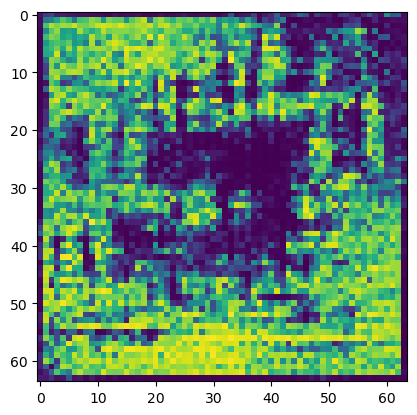

epoch = 451
Gen loss = tf.Tensor(0.08461747, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.042991553, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 452
Gen loss = tf.Tensor(0.07720094, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.049826127, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 453
Gen loss = tf.Tensor(0.07990173, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.046289388, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 454
Gen loss = tf.Tensor(0.08063688, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.049607243, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 455
Gen loss = tf.Tensor(0.07939743, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04674646, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 456
Gen loss = tf.Tensor(0.07784385, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.047255788, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 457
Gen loss = tf.Tensor(0.08149112, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0488649

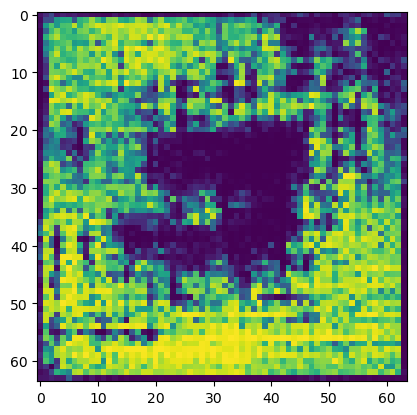

epoch = 461
Gen loss = tf.Tensor(0.07252416, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.056105245, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 462
Gen loss = tf.Tensor(0.08241446, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.045389816, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 463
Gen loss = tf.Tensor(0.07800275, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.051203847, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 464
Gen loss = tf.Tensor(0.07808917, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.050101932, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 465
Gen loss = tf.Tensor(0.08137246, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.047724932, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 466
Gen loss = tf.Tensor(0.07588274, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.05027039, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 467
Gen loss = tf.Tensor(0.08068367, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0481637

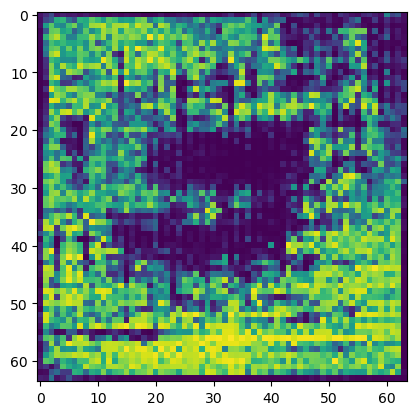

epoch = 471
Gen loss = tf.Tensor(0.08708625, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04696949, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 472
Gen loss = tf.Tensor(0.08285188, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.043410946, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 473
Gen loss = tf.Tensor(0.08498049, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.044197965, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 474
Gen loss = tf.Tensor(0.08531397, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.044594392, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 475
Gen loss = tf.Tensor(0.08172866, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.045462012, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 476
Gen loss = tf.Tensor(0.08039928, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04807523, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 477
Gen loss = tf.Tensor(0.0849756, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.043474182

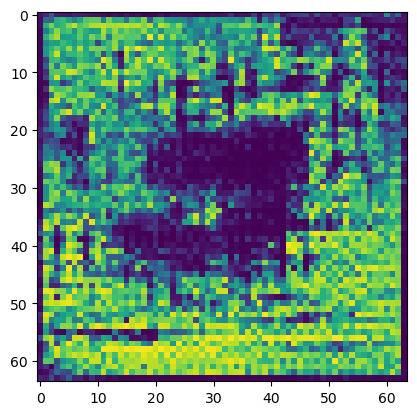

epoch = 481
Gen loss = tf.Tensor(0.08567318, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04381357, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 482
Gen loss = tf.Tensor(0.083140485, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.049341332, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 483
Gen loss = tf.Tensor(0.075628705, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04648592, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 484
Gen loss = tf.Tensor(0.0848879, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04442506, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 485
Gen loss = tf.Tensor(0.08608063, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04281741, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 486
Gen loss = tf.Tensor(0.089410685, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.039496306, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 487
Gen loss = tf.Tensor(0.0865353, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.045767654

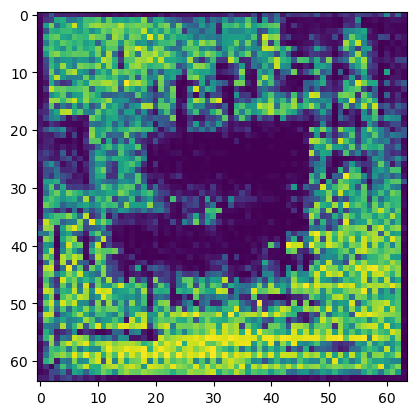

epoch = 491
Gen loss = tf.Tensor(0.08668917, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.043515075, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 492
Gen loss = tf.Tensor(0.08656972, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.044537053, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 493
Gen loss = tf.Tensor(0.08519498, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04550152, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 494
Gen loss = tf.Tensor(0.08656845, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0456811, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 495
Gen loss = tf.Tensor(0.08609035, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.044040706, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 496
Gen loss = tf.Tensor(0.086514145, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.045383397, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 497
Gen loss = tf.Tensor(0.08344991, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.05411900

In [327]:

gen_losses, disc_losses, generated_map, disc_accuracies = train(training_data, N_EPOCHS)


Denormalize, save and display generated map output

(64, 64)


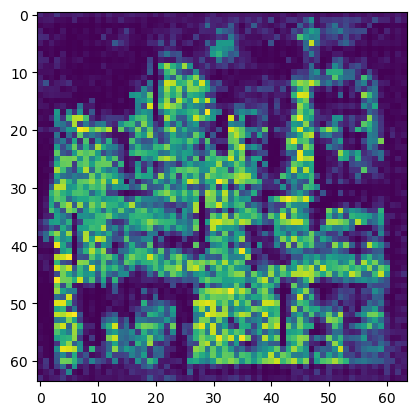

In [328]:
# denormalise generated map

generated_map *= 255

generated_map = generated_map.numpy()

generated_map = np.reshape(generated_map, (64,64))

generated_map = np.round(generated_map,0)
print(generated_map.shape)

#write generated map to csv


np.savetxt('generated_map.csv', generated_map, delimiter=',', fmt='%i')

generated_map = generated_map.tolist()


plt.imshow(generated_map)

# Graphs:

Losses

Text(0.5, 0, 'Epoch')

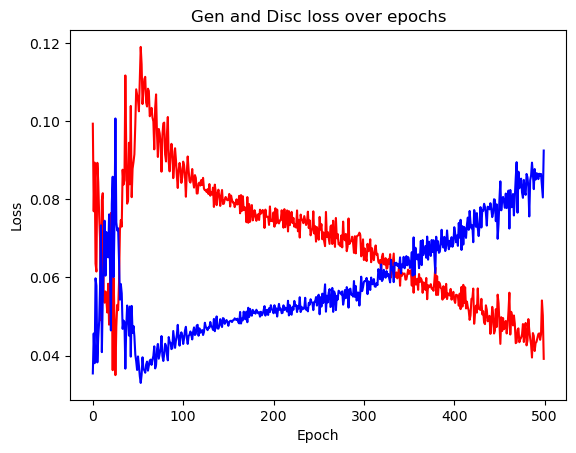

In [329]:
epoch_list = [i for i in range(0,N_EPOCHS)]


plt.plot(epoch_list, disc_losses,  'r-')
plt.plot(epoch_list, gen_losses, 'b-')
plt.title('Gen and Disc loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')

Discriminator Accuracy

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3500,) + inhomogeneous part.

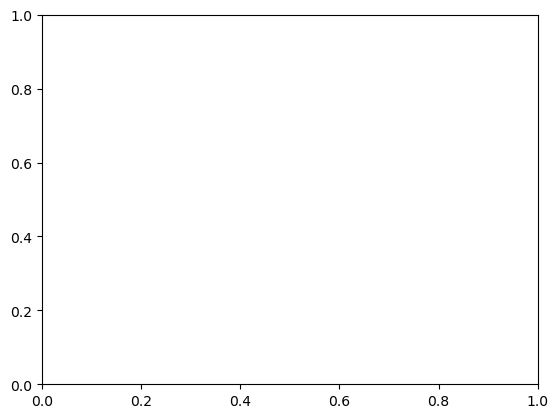

In [330]:
plt.plot(epoch_list, disc_accuracies,  'r-')

plt.title('Disc accuracy over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')